In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.12.0


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

4422102/4422102 [==============================] - 0s 0us/step


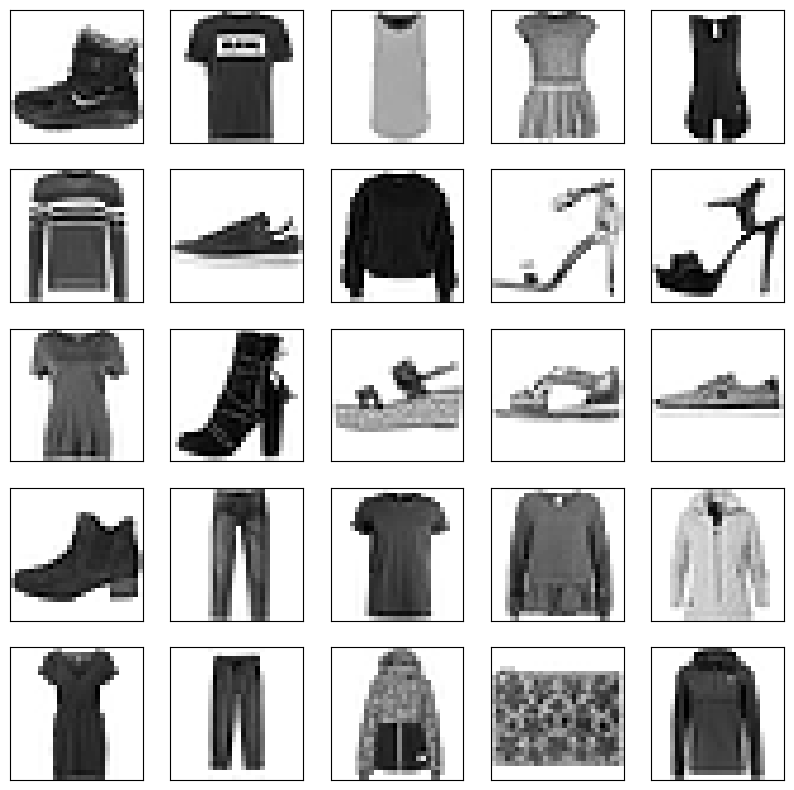

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
batch_size = 32
# This dataset fills a buffer with buffer_size elements, 
#then randomly samples elements from this buffer, replacing the selected elements with new elements.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
#Combines consecutive elements of this dataset into batches.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
#Creates a Dataset that prefetches elements from this dataset

In [ ]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

In [ ]:
pip install plot-utils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 40.9 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.utils import plot_model
import plot_utils

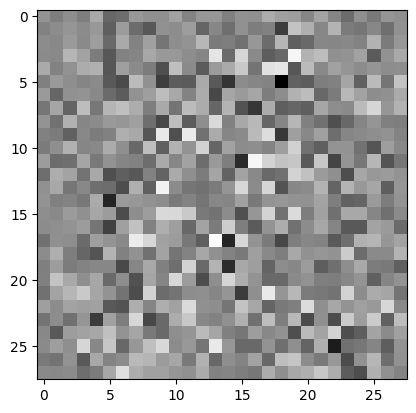

In [ ]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
plt.imshow(generated_images[0, :, :, 0], cmap='gray')
plt.show()


In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
decision = discriminator(generated_images)
#resultant output closer to 0 means fake, and 1 means real image
print(decision)

tf.Tensor([[0.49841532]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
#set trainable to false as we only train generator for now
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
from IPython import display
from tqdm import tqdm
#generate a random noise and track its image and as the gan trains through various epochs of training
#here 100 is the num 0f features
seed = tf.random.normal(shape=[batch_size, 100])

In [ ]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=2):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            #creating mini batch of fake images using generator
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            #now concatenate real and fake images
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            #set class label. real=1, fake =0
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [ ]:
#batching and shuffling mnist data again
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

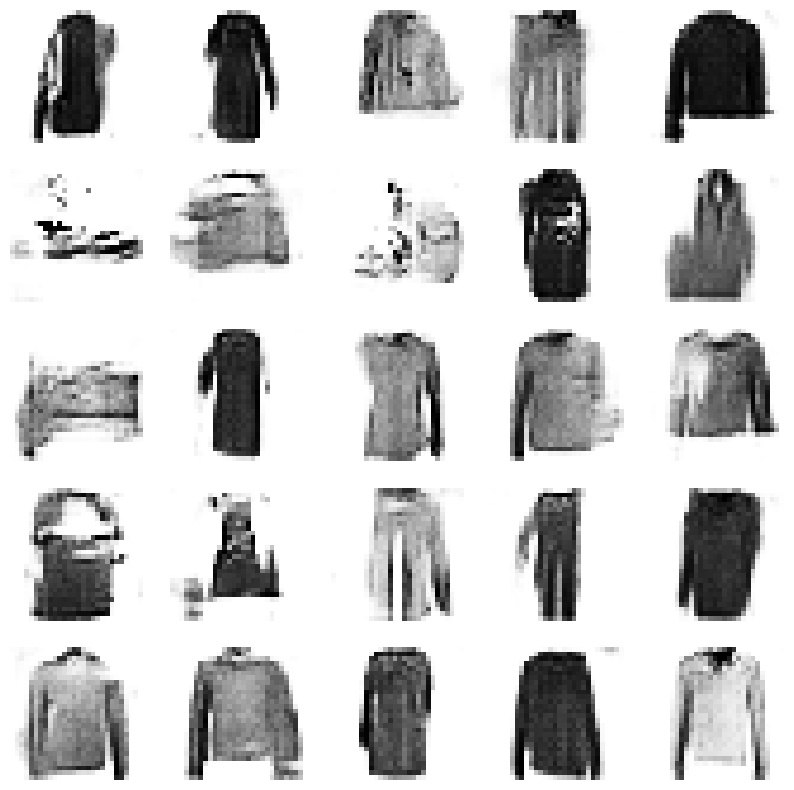

In [ ]:
train_dcgan(gan, dataset, batch_size, num_features, epochs=2)

In [ ]:
import tensorflow as tf
batc_size=16

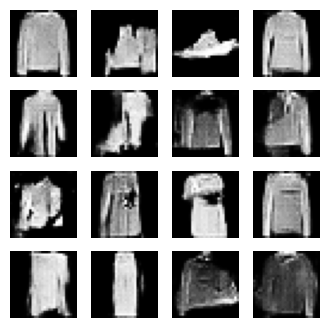

In [ ]:
noise = tf.random.normal(shape=[batc_size, num_features])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from skimage.transform import resize

def inception_score(images, n_split=10):
    # Load the inceptionv3 model and remove the last softmax layer
    base_model = InceptionV3(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

    # Resize images to 299x299
    images_resized = np.array([resize(img, (299, 299), preserve_range=True) for img in images])

    # Scale pixel values to [-1, 1]
    images_resized = (images_resized.astype(np.float32) / 127.5) - 1.0

    # Preprocess the images for the Inceptionv3 model
    images_preprocessed = preprocess_input(images_resized)

    # Get the predicted features from the Inceptionv3 model
    features = model.predict(images_preprocessed)

    # Calculate the mean and covariance of the predicted features
    mean_features = np.mean(features, axis=0)
    cov_features = np.cov(features, rowvar=False)

    # Calculate the scores for each split
    scores = []
    split_size = features.shape[0] // n_split
    for i in range(n_split):
        split_features = features[i*split_size:(i+1)*split_size, :]
        split_mean = np.mean(split_features, axis=0)
        split_cov = np.cov(split_features, rowvar=False)
        split_score = np.sum((split_mean - mean_features)**2 + np.trace(split_cov + cov_features - 2*np.sqrt(split_cov @ cov_features @ split_cov)))
        scores.append(split_score)

    # Calculate the Inception score
    inception_score = np.exp(np.mean(scores))

    return inception_score


In [ ]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise, training=False)
generated_images = tf.tile(generated_images, [1, 1, 3])
score = inception_score(generated_images.numpy())
print("Inception score:", score)


In [ ]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
display.Image(filename=anim_file)